<a href="https://colab.research.google.com/github/sophiapyx/IAT360-Computer-Vision-Project---Group-36/blob/main/Computer_Vision_Project_Group_36.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
from PIL import Image

base_dir = "Desktop/datasets_cat"
output_dir = os.path.join(base_dir, "converted_yolo")

class_map = {"pain": 1, "no_pain": 0}
valid_exts = (".png", ".jpg", ".jpeg")

os.makedirs(output_dir, exist_ok=True)
for cls in class_map:
    os.makedirs(os.path.join(output_dir, cls, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, cls, "labels"), exist_ok=True)

def convert_bbox_to_yolo(bbox, img_w, img_h):
    x_min, y_min, x_max, y_max = bbox
    x_c = (x_min + x_max) / 2.0 / img_w
    y_c = (y_min + y_max) / 2.0 / img_h
    w   = (x_max - x_min) / img_w
    h   = (y_max - y_min) / img_h
    return x_c, y_c, w, h

for cls_name, cls_id in class_map.items():
    img_dir = os.path.join(base_dir, cls_name, "images")
    label_dir = os.path.join(base_dir, cls_name, "labels")
    out_img_dir = os.path.join(output_dir, cls_name, "images")
    out_lbl_dir = os.path.join(output_dir, cls_name, "labels")

    for fname in os.listdir(img_dir):
        lf = fname.lower()
        if not lf.endswith(valid_exts):
            continue

        base = os.path.splitext(fname)[0]
        img_path = os.path.join(img_dir, fname)
        json_path = os.path.join(label_dir, base + ".json")


        with Image.open(img_path) as im:
            w, h = im.size


        with open(json_path, "r") as f:
            data = json.load(f)
        bbox = data["bounding_boxes"]


        x_c, y_c, bw, bh = convert_bbox_to_yolo(bbox, w, h)
        with open(os.path.join(out_lbl_dir, base + ".txt"), "w") as f:
            f.write(f"{cls_id} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}\n")


        with Image.open(img_path) as im:
            im.save(os.path.join(out_img_dir, fname))


In [12]:
import os

labels_dir = "Desktop/final_datasets_cat/labels"

pain_count = 0
no_pain_count = 0
total_files = 0

for file in os.listdir(labels_dir):
    if file.endswith(".txt"):
        total_files += 1
        file_path = os.path.join(labels_dir, file)
        with open(file_path, "r") as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if not parts:
                    continue
                cls = parts[0]
                if cls == "1":
                    pain_count += 1
                elif cls == "0":
                    no_pain_count += 1

print("tital：")
print(f"total_files: {total_files}")
print(f"Pain (class 1) labels: {pain_count}")
print(f"No Pain (class 0) labels: {no_pain_count}")


tital：
total_files: 2079
Pain (class 1) labels: 266
No Pain (class 0) labels: 1831


In [13]:
import os, random, shutil
from collections import defaultdict


BASE = "Desktop/final_datasets_cat"
IMAGES_DIR = os.path.join(BASE, "images")
LABELS_DIR = os.path.join(BASE, "labels")
OUT = os.path.join(BASE, "final_dataset")

SPLIT = 0.8
SEED = 42
IMG_EXTS = (".png", ".jpg", ".jpeg")


for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    os.makedirs(os.path.join(OUT, sub), exist_ok=True)

random.seed(SEED)

def stem(p):
    return os.path.splitext(p)[0]

images = {stem(f): f for f in os.listdir(IMAGES_DIR) if f.lower().endswith(IMG_EXTS)}
labels = {stem(f): f for f in os.listdir(LABELS_DIR) if f.endswith(".txt")}

common_keys = sorted(set(images.keys()) & set(labels.keys()))
if not common_keys:
    raise RuntimeError()


def is_pain_label(txt_path):
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 1 and parts[0] == "1":
                return True
    return False

pain_keys = []
nopain_keys = []
for k in common_keys:
    if is_pain_label(os.path.join(LABELS_DIR, labels[k])):
        pain_keys.append(k)
    else:
        nopain_keys.append(k)


def split_keys(keys, ratio):
    n = len(keys)
    idx = list(range(n))
    random.shuffle(idx)
    cut = int(n * ratio)
    train = [keys[i] for i in idx[:cut]]
    val   = [keys[i] for i in idx[cut:]]
    return train, val

pain_train, pain_val     = split_keys(pain_keys, SPLIT)
nopain_train, nopain_val = split_keys(nopain_keys, SPLIT)

train_keys = pain_train + nopain_train
val_keys   = pain_val   + nopain_val

def copy_pair(key, subset):
    img_src = os.path.join(IMAGES_DIR, images[key])
    lbl_src = os.path.join(LABELS_DIR, labels[key])
    img_dst = os.path.join(OUT, "images", subset, images[key])
    lbl_dst = os.path.join(OUT, "labels", subset, labels[key])
    shutil.copy(img_src, img_dst)
    shutil.copy(lbl_src, lbl_dst)

for k in train_keys:
    copy_pair(k, "train")
for k in val_keys:
    copy_pair(k, "val")

yaml_path = os.path.join(OUT, "data.yaml")
with open(yaml_path, "w", encoding="utf-8") as f:
    f.write(
f"""# YOLO data config

path: {OUT}
train: images/train
val: images/val

nc: 2
names:
  0: no_pain
  1: pain
"""
    )

print("Split done!")
print(f"Images with labels (pairs): {len(common_keys)}")
print(f"Pain total:    {len(pain_keys)}  -> train {len(pain_train)} / val {len(pain_val)}")
print(f"No-pain total: {len(nopain_keys)} -> train {len(nopain_train)} / val {len(nopain_val)}")
print(f"\n output：{OUT}")
print(f"- data.yaml")
print(f"- images/train, images/val")
print(f"- labels/train, labels/val")


Split done!
Images with labels (pairs): 2079
Pain total:    266  -> train 212 / val 54
No-pain total: 1813 -> train 1450 / val 363

 output：Desktop/final_datasets_cat/final_dataset
- data.yaml
- images/train, images/val
- labels/train, labels/val


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
!mkdir -p "/content/gdrive/MyDrive/cat_pain_project/runs"
!rm -rf /content/runs
!ln -s "/content/gdrive/MyDrive/cat_pain_project/runs" /content/runs


In [8]:
import os

DATASET_ROOT = "/content/gdrive/MyDrive/Colab Notebooks/final_datasets_cat"

IMAGES_DIR = os.path.join(DATASET_ROOT, "images")
LABELS_DIR = os.path.join(DATASET_ROOT, "labels")

def count_files(base_path, exts):

    counts = {}
    total = 0
    for subset in ["train", "val"]:
        subset_path = os.path.join(base_path, subset)
        count = 0
        if os.path.exists(subset_path):
            for f in os.listdir(subset_path):
                if not f.startswith('.') and f.lower().endswith(exts):
                    count += 1
        counts[subset] = count
        total += count
    counts["total"] = total
    return counts

if os.path.exists(IMAGES_DIR):
    img_counts = count_files(IMAGES_DIR, ('.jpg', '.png', '.jpeg'))
    print(" Image counts:")
    print(f"  Train: {img_counts['train']}")
    print(f"  Val:   {img_counts['val']}")
    print(f"  Total: {img_counts['total']}\n")

if os.path.exists(LABELS_DIR):
    label_counts = count_files(LABELS_DIR, ('.txt',))
    print(" Label counts:")
    print(f"  Train: {label_counts['train']}")
    print(f"  Val:   {label_counts['val']}")
    print(f"  Total: {label_counts['total']}")


 Image counts:
  Train: 1662
  Val:   417
  Total: 2079

 Label counts:
  Train: 1662
  Val:   417
  Total: 2079


In [9]:
!pip3 install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.7/107.7 GB disk)


In [4]:
import ultralytics
print("YOLOv8", ultralytics.__version__)

YOLOv8 8.3.221


In [11]:

import ultralytics
from ultralytics import YOLO

ultralytics.checks()

print("\n--- YOLOv8 Environmental inspection completed (CPU) ---")

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.7/107.7 GB disk)

--- YOLOv8 Environmental inspection completed (CPU) ---



image 1/1 /content/gdrive/MyDrive/Colab Notebooks/final_datasets_cat/images/train/00000001_000.png: 640x480 1 cat, 1 bed, 199.7ms
Speed: 4.6ms preprocess, 199.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/gdrive/MyDrive/cat_pain_project/runs/dataset_check


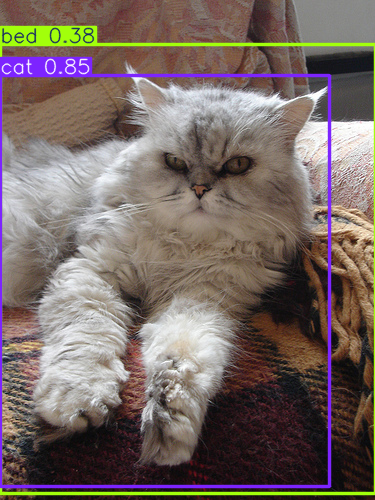

In [13]:
%matplotlib inline
from ultralytics import YOLO
from PIL import Image
from google.colab.patches import cv2_imshow

model = YOLO('yolov8n.pt')

image_path = "/content/gdrive/MyDrive/Colab Notebooks/final_datasets_cat/images/train/00000001_000.png"

results = model.predict(source=image_path, save=True, project="/content/gdrive/MyDrive/cat_pain_project/runs", name="dataset_check")

for r in results:
    im_array = r.plot()
    im = Image.fromarray(im_array[..., ::-1])
    cv2_imshow(im_array)
    im.save("/content/gdrive/MyDrive/cat_pain_project/runs/dataset_check/result_00000001_000.png")  # 保存可视化图像
